# Применение XGBoost

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.style.use('ggplot')
%matplotlib inline

Задача. Нужно научиться распознавать доход человека (больше $50000 в год или меньше) по его ответам в ходе переписи населения.
Данные
https://archive.ics.uci.edu/ml/datasets/Adult

Описание данных:
https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

In [2]:
# Имена переменных
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Читаем и обрабатываем обучающую выборку
df = pd.read_csv('adult.data', header=None, names=columns, na_values=' ?')
# Удаляем колонку education (потому что есть уже закодированная колонка education-num)
df = df.drop('education', axis=1)
# Кодируем отклик значениями 0 и 1
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
# удаляем строки с NA значениями
df = df.dropna()

# Читаем и обрабатываем тестовую выборку, как выше
test = pd.read_csv('adult.test', header=None, names=columns, na_values=' ?', skiprows=1)
test = test.drop('education', axis=1)
test['income'] = test['income'].map({' <=50K.': 0, ' >50K.': 1})
test = test.dropna()

In [3]:
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Распределение классов

In [4]:
df['income'].value_counts(normalize=True)

0    0.751078
1    0.248922
Name: income, dtype: float64

Делаем обучающую и тестовую выборку

In [5]:
X_train = pd.get_dummies(df).drop('income', axis=1)
y_train = df['income']

X_test = pd.get_dummies(test).drop('income', axis=1)
y_test = test['income']

В обучающем множестве содержится на один столбец больше.

In [6]:
print (len(X_train.columns))
print (len(X_test.columns))

88
87


В тестовой выборке нет ни одного представителя Голландии 
в колонке ```native-county```.

In [7]:
# Приводим множество названий колонок к типу set, находим разность двух множеств.
print(set(X_train.columns) - set(X_test.columns))
print(set(X_test.columns) - set(X_train.columns))

{'native-country_ Holand-Netherlands'}
set()


Создадим полный список всех колонок (из обучающего и тестового множеств) и переиндексируем колонки в соответствии с этим списком. В результате в колонке ```native-country_ Holand-Netherlands``` в тестовом множестве появятся NaN-значения, которые мы заменим на нули.

In [8]:
columns = set(X_train.columns) | set(X_test.columns)
X_train = X_train.reindex(columns=columns).fillna(0)
X_test = X_test.reindex(columns=columns).fillna(0)

In [9]:
X_train

,native-country_ Cambodia,workclass_ Local-gov,native-country_ Laos,native-country_ Greece,native-country_ South,native-country_ United-States,occupation_ Machine-op-inspct,native-country_ Hungary,native-country_ China,workclass_ Federal-gov,...,workclass_ Without-pay,native-country_ Iran,occupation_ Craft-repair,occupation_ Other-service,capital-gain,native-country_ Portugal,hours-per-week,native-country_ Taiwan,native-country_ Italy,occupation_ Exec-managerial
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,2174,0,40,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,13,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,40,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,40,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,40,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,38,0,0,0
32557,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,40,0,0,0
32558,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,40,0,0,0
32559,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,20,0,0,0


# XGBoost

In [10]:
from xgboost import XGBClassifier
from sklearn import metrics

Обучим базовую модель без подбора параметров

In [11]:
baseline_model = XGBClassifier(random_state=9845)
baseline_model.fit(X_train, y_train)

y_pred_train = baseline_model.predict(X_train)
print (metrics.classification_report(y_train, y_pred_train))

y_pred_test = baseline_model.predict(X_test)
print (metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93     22654
           1       0.84      0.73      0.78      7508

    accuracy                           0.90     30162
   macro avg       0.88      0.84      0.86     30162
weighted avg       0.90      0.90      0.90     30162

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     11360
           1       0.77      0.66      0.71      3700

    accuracy                           0.87     15060
   macro avg       0.83      0.80      0.81     15060
weighted avg       0.86      0.87      0.87     15060



In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

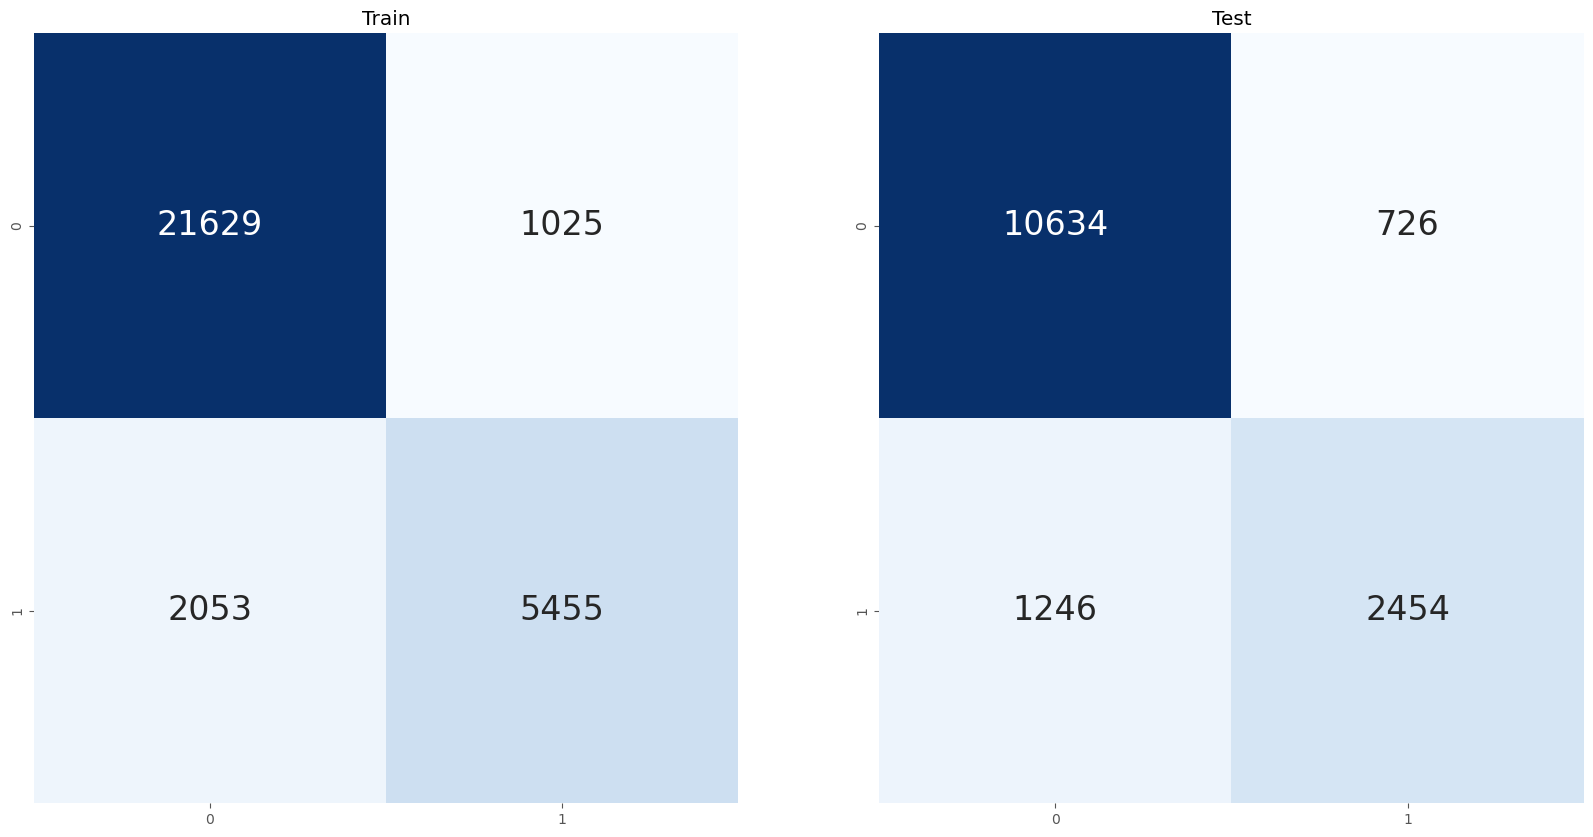

In [13]:
fig,ax=plt.subplots(1, 2, figsize=(20,10))

ax = ax.ravel()

cm = confusion_matrix(y_train, y_pred_train)
ax[0].set_title('Train')
sns.heatmap(cm, ax=ax[0], annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

cm = confusion_matrix(y_test, y_pred_test)
ax[1].set_title('Test')
sns.heatmap(cm, ax=ax[1], annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

In [14]:
print("Accuracy on train set is ", metrics.accuracy_score(y_train, y_pred_train)*100)
print("Accuracy on test set is ", metrics.accuracy_score(y_test, y_pred_test)*100)

Accuracy on train set is  89.79510642530336
Accuracy on test set is  86.90571049136786


## Подбор параметров с использованием Optuna

In [15]:
import optuna
from optuna.distributions import IntDistribution, FloatDistribution
from optuna.integration import OptunaSearchCV

In [16]:
xgb_params = {'n_estimators': IntDistribution(low=10, high=300,step=10),
              'learning_rate' : FloatDistribution(low=0.01, high=1.1),
              'max_depth': IntDistribution(low=1, high=20,step=2),
              'gamma' : FloatDistribution(low=0.0001, high=0.5),
              'subsample' : FloatDistribution(low=0.5, high=1.0),
              'colsample_bytree' : FloatDistribution(low=0.5, high=1.0),
              'reg_alpha' : FloatDistribution(low=0.5, high=3.0)
}
xgb_gs=OptunaSearchCV(estimator=XGBClassifier(random_state=9845),
                      scoring='f1',
                      param_distributions=xgb_params,
                      cv=5,
                      n_jobs=-1,
                      random_state=9845);

C:\ProgramData\Anaconda3\lib\site-packages\optuna\distributions.py:716: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
C:\Temp\ipykernel_4376\1618054829.py:9: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  xgb_gs=OptunaSearchCV(estimator=XGBClassifier(random_state=9845),


In [17]:
xgb_gs.fit(X_train, y_train)
print("best score: ", xgb_gs.best_score_)
print("best param: ", xgb_gs.best_params_)

[I 2023-04-18 13:38:55,023] A new study created in memory with name: no-name-81496b13-063e-4678-9239-f1e7b2ab00cb
[I 2023-04-18 13:38:58,374] Trial 6 finished with value: 0.6643858152024111 and parameters: {'n_estimators': 30, 'learning_rate': 0.8608479512766143, 'max_depth': 1, 'gamma': 0.31597053560105365, 'subsample': 0.6830778747295878, 'colsample_bytree': 0.6262436214638006, 'reg_alpha': 2.1709818251593767}. Best is trial 6 with value: 0.6643858152024111.
[I 2023-04-18 13:39:02,132] Trial 0 finished with value: 0.6842040152730448 and parameters: {'n_estimators': 10, 'learning_rate': 1.0665915398300465, 'max_depth': 9, 'gamma': 0.029200835992161105, 'subsample': 0.5161189972515436, 'colsample_bytree': 0.6747556652380419, 'reg_alpha': 2.5416256871052747}. Best is trial 0 with value: 0.6842040152730448.
[I 2023-04-18 13:39:10,721] Trial 5 finished with value: 0.7044460031138682 and parameters: {'n_estimators': 110, 'learning_rate': 0.8990112544201446, 'max_depth': 3, 'gamma': 0.07719

best score:  0.7097837132736073
best param:  {'n_estimators': 120, 'learning_rate': 0.08659489937857852, 'max_depth': 7, 'gamma': 0.216676671345128, 'subsample': 0.5287293231141255, 'colsample_bytree': 0.9354723137590631, 'reg_alpha': 2.8570608418979933}


In [18]:
model = xgb_gs.best_estimator_
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print (metrics.classification_report(y_train, y_pred_train))

y_pred_test = model.predict(X_test)
print (metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92     22654
           1       0.81      0.69      0.75      7508

    accuracy                           0.88     30162
   macro avg       0.86      0.82      0.84     30162
weighted avg       0.88      0.88      0.88     30162

              precision    recall  f1-score   support

           0       0.89      0.94      0.91     11360
           1       0.77      0.66      0.71      3700

    accuracy                           0.87     15060
   macro avg       0.83      0.80      0.81     15060
weighted avg       0.86      0.87      0.86     15060



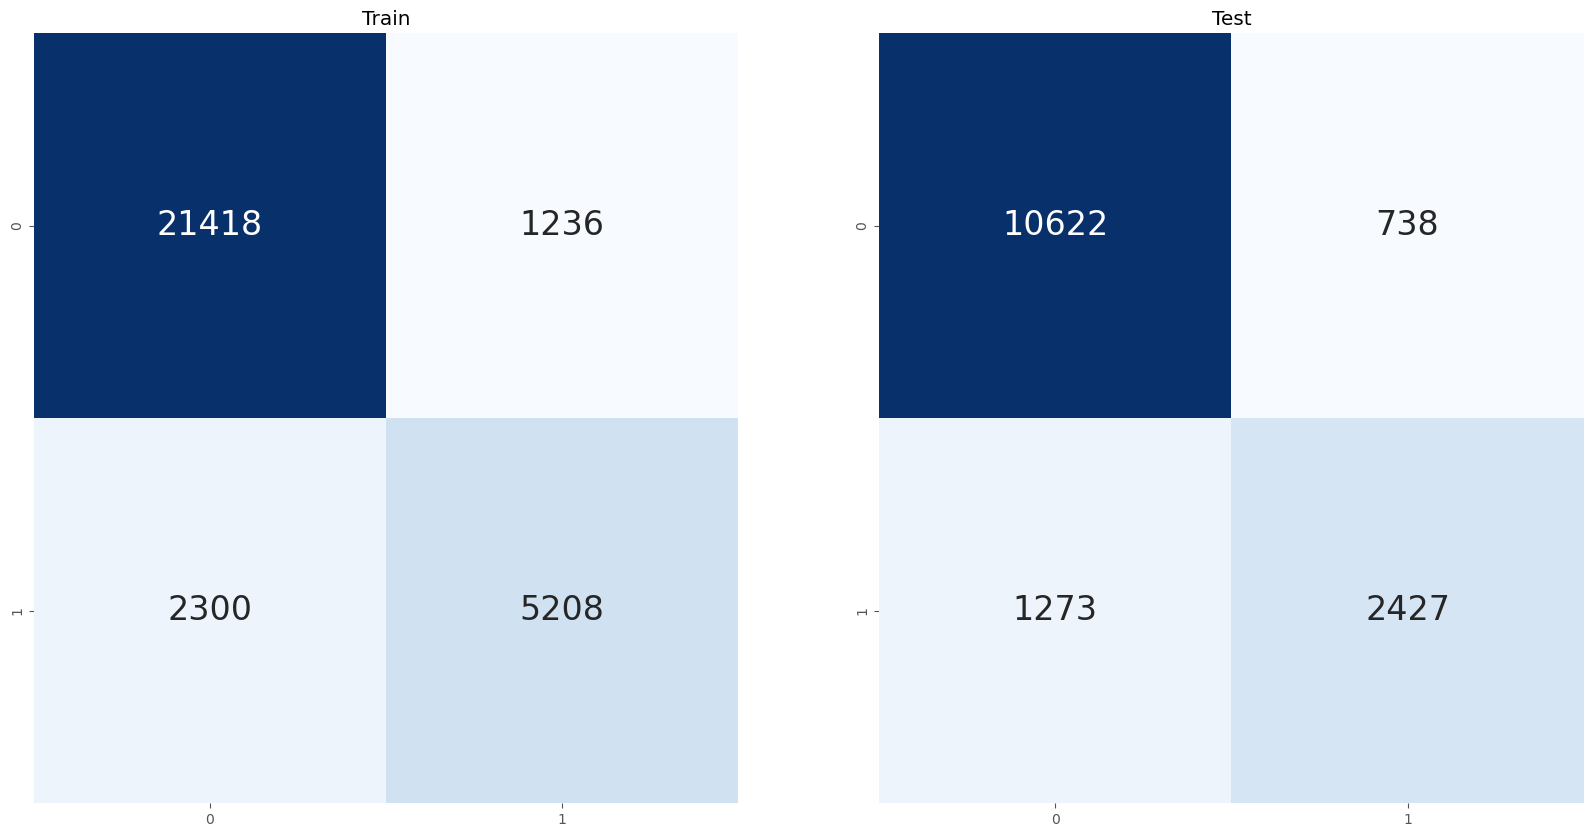

In [19]:
fig,ax=plt.subplots(1, 2, figsize=(20,10))

ax = ax.ravel()

cm = confusion_matrix(y_train, y_pred_train)
ax[0].set_title('Train')
sns.heatmap(cm, ax=ax[0], annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

cm = confusion_matrix(y_test, y_pred_test)
ax[1].set_title('Test')
sns.heatmap(cm, ax=ax[1], annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

In [20]:
print("Accuracy on train set is ", metrics.accuracy_score(y_train, y_pred_train)*100)
print("Accuracy on test set is ", metrics.accuracy_score(y_test, y_pred_test)*100)

Accuracy on train set is  88.27663948014057
Accuracy on test set is  86.64674634794157
